In [1]:
# ── 0) Interactive backend & quiet TF logs ─────────────────────────────
try:
    get_ipython().run_line_magic("matplotlib", "widget")
except Exception:
    pass

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # quiet TensorFlow logs

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as W

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, ReLU
from tensorflow.keras.models import Model
from pathlib import Path

In [2]:
# ── 1) Paths (edit if needed) ──────────────────────────────────────────
RESULTS_DIR       = Path("..") / "data" / "nucleus-ae" 
CENTERS_NPZ       = os.path.join(RESULTS_DIR, "latent_centers.npz")
DECODER_WEIGHTS   = os.path.join(RESULTS_DIR, "decoder_weights.h5")

# model constants (must match training)# ── 2) GPU memory growth (safe even if no GPU) ─────────────────────────
try:
    gpus = tf.config.list_physical_devices("GPU")
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass
IMG_SHAPE   = (256, 256, 1)
LATENT_SIDE = 16     # after 4× AveragePooling2D from 256 → 16
BASE_CH     = 128


In [3]:
# ── 2) GPU memory growth (safe even if no GPU) ─────────────────────────
try:
    gpus = tf.config.list_physical_devices("GPU")
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
except Exception:
    pass


In [4]:
# ── 3) Rebuild decoder to match your training script ───────────────────
def build_decoder(latent_dim: int) -> Model:
    z_in = Input((latent_dim,), name="z_sampling")
    x = Dense(LATENT_SIDE * LATENT_SIDE * BASE_CH)(z_in)
    x = Reshape((LATENT_SIDE, LATENT_SIDE, BASE_CH))(x)
    for f in [BASE_CH, 64, 32, 16]:
        x = Conv2DTranspose(f, 3, strides=2, padding="same")(x); x = ReLU()(x)
        x = Conv2D(f, 3, padding="same")(x); x = ReLU()(x)
    out = Conv2D(1, 3, padding="same", activation="sigmoid", name="decoder_output")(x)
    return Model(z_in, out, name="decoder")

# Load latent centers
npz = np.load(CENTERS_NPZ)
z_mean     = npz["mean"].astype(np.float32)
z_median   = npz["median"].astype(np.float32)
z_geomed   = npz["geomedian"].astype(np.float32)
latent_dim = int(z_mean.shape[0])

# Build and load decoder weights
decoder = build_decoder(latent_dim)
decoder.load_weights(DECODER_WEIGHTS)
decoder.trainable = False

# Decode all three
def _decode(z_vec):
    z_vec = np.asarray(z_vec, dtype=np.float32)[None, ...]  # (1, D)
    x = decoder.predict(z_vec, verbose=0)[0, ..., 0]        # in [0,1]
    x = (x * 255.0).astype(np.float32)                      # now 0–255 float
    return x

img_mean   = _decode(z_mean)
img_median = _decode(z_median)
img_geomed = _decode(z_geomed)

imgs = [img_mean, img_median, img_geomed]
titles = ["Mean", "Median", "Geometric median"]


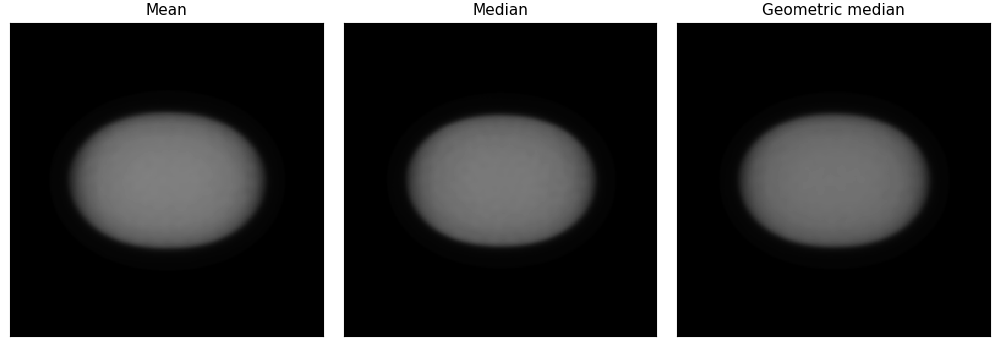

In [5]:
#| label: ae1m-theoretical

# ── 4) Interactive figure with 0–255 Intensity slider (non-editable readout) ──
fig, axes = plt.subplots(1, 3, figsize=(10, 3.4), constrained_layout=True)
ims = []
for ax, arr, title in zip(axes, imgs, titles):
    # 'nearest' = nearest-neighbor (no smoothing)
    im = ax.imshow(arr, cmap="gray", vmin=0.0, vmax=255.0, interpolation="nearest")
    ax.set_title(title, fontsize=11)
    ax.set_xticks([]); ax.set_yticks([])
    ims.append(im)

# Non-editable range display
rng = W.IntRangeSlider(
    value=[0, 255],
    min=0, max=255, step=1,
    description="Intensity",
    continuous_update=True,
    readout=False,  # hide the editable textbox
    layout=W.Layout(width="600px")
)
val_label = W.Label(f"range: {rng.value[0]} – {rng.value[1]}")

def on_range_change(change):
    vmin, vmax = change["new"]
    if vmax <= vmin:
        return
    for im in ims:
        im.set_clim(vmin=float(vmin), vmax=float(vmax))
    val_label.value = f"range: {vmin} – {vmax}"
    fig.canvas.draw_idle()

rng.observe(on_range_change, names="value")

display(W.HBox([rng, val_label]))
plt.show()
